In [2]:
import os
import numpy as np
import cv2
import random
import tensorflow as tf
from tensorflow.keras import layers, models, callbacks, regularizers
from tensorflow.keras.applications import EfficientNetV2S
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.cm as cm

In [31]:
IMG_SIZE = 224
BATCH_SIZE = 32
EPOCHS = 20
DATA_DIR = r"C:\Users\anuvv\FINAL PROJECT\CONOP"  # <-- Change this to your actual path
CLASS_NAMES = ["pneumonia", "normal", "covid"]

In [15]:
# --------------------------
# CLAHE Preprocessing
# --------------------------
def apply_clahe(img):
    lab = cv2.cvtColor(img, cv2.COLOR_BGR2LAB)
    l, a, b = cv2.split(lab)
    clahe = cv2.createCLAHE(clipLimit=2.0)
    cl = clahe.apply(l)
    merged = cv2.merge((cl, a, b))
    return cv2.cvtColor(merged, cv2.COLOR_LAB2BGR)

In [17]:
def load_balanced_data():
    X_train, X_val, y_train, y_val = [], [], [], []

    for idx, cls in enumerate(CLASS_NAMES):
        folder_path = os.path.join(DATA_DIR, cls)
        images = []
        for file in os.listdir(folder_path):
            img_path = os.path.join(folder_path, file)
            img = cv2.imread(img_path)
            if img is not None:
                img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
                img = apply_clahe(img)
                img = img / 255.0
                images.append(img)

        # Split equally
        train_imgs, val_imgs = train_test_split(images, test_size=0.2, random_state=42)
        X_train.extend(train_imgs)
        y_train.extend([idx] * len(train_imgs))
        X_val.extend(val_imgs)
        y_val.extend([idx] * len(val_imgs))

    X_train = np.array(X_train)
    y_train = to_categorical(np.array(y_train), num_classes=3)
    X_val = np.array(X_val)
    y_val = to_categorical(np.array(y_val), num_classes=3)
    return X_train, X_val, y_train, y_val

X_train, X_val, y_train, y_val = load_balanced_data()

In [19]:
print(X_train.shape)
print(X_val.shape)
print(y_train.shape)
print(y_val.shape)

(5550, 224, 224, 3)
(1389, 224, 224, 3)
(5550, 3)
(1389, 3)


In [21]:
# --------------------------
# Build Model
# --------------------------
def build_model():
    base_model = EfficientNetV2S(include_top=False, input_shape=(IMG_SIZE, IMG_SIZE, 3), weights="imagenet")
    base_model.trainable = True
    model = models.Sequential([
        base_model,
        layers.GlobalAveragePooling2D(),
        layers.BatchNormalization(),
        layers.Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
        layers.BatchNormalization(),
        layers.Dropout(0.3),
        layers.Dense(3, activation='softmax')
    ])
    return model

In [29]:
model = build_model()
from tensorflow.keras.metrics import AUC

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
    loss='categorical_crossentropy',
    metrics=[
        'accuracy',
        AUC(name='auc', multi_label=False)
    ]
)


# --------------------------
# Callbacks
# --------------------------
early_stop = callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, verbose=1)


In [33]:
history = model.fit(X_train, y_train,
                    validation_data=(X_val, y_val),
                    epochs=EPOCHS,
                    batch_size=BATCH_SIZE,
                    callbacks=[early_stop, reduce_lr])

Epoch 1/20
174/174 ━━━━━━━━━━━━━━━━━━━━ 1188s 6s/step - accuracy: 0.7666 - auc: 0.9003 - loss: 0.8909 - val_accuracy: 0.9194 - val_auc: 0.9827 - val_loss: 0.5169 - learning_rate: 1.0000e-04
Epoch 2/20
174/174 ━━━━━━━━━━━━━━━━━━━━ 1086s 6s/step - accuracy: 0.9327 - auc: 0.9875 - loss: 0.4299 - val_accuracy: 0.9374 - val_auc: 0.9891 - val_loss: 0.4158 - learning_rate: 1.0000e-04
Epoch 3/20
174/174 ━━━━━━━━━━━━━━━━━━━━ 1041s 6s/step - accuracy: 0.9498 - auc: 0.9933 - loss: 0.3739 - val_accuracy: 0.8992 - val_auc: 0.9747 - val_loss: 0.5437 - learning_rate: 1.0000e-04
Epoch 4/20
174/174 ━━━━━━━━━━━━━━━━━━━━ 1047s 6s/step - accuracy: 0.9704 - auc: 0.9970 - loss: 0.3181 - val_accuracy: 0.9518 - val_auc: 0.9871 - val_loss: 0.4226 - learning_rate: 1.0000e-04
Epoch 5/20
174/174 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - accuracy: 0.9660 - auc: 0.9970 - loss: 0.3135   
Epoch 5: ReduceLROnPlateau reducing learning rate to 4.999999873689376e-05.
174/174 ━━━━━━━━━━━━━━━━━━━━ 1037s 6s/step - accuracy: 0.9661 

In [37]:
results = model.evaluate(X_val, y_val)
print(f"Evaluation Results: {results}")


44/44 ━━━━━━━━━━━━━━━━━━━━ 49s 1s/step - accuracy: 0.9448 - auc: 0.9829 - loss: 0.4711
Evaluation Results: [0.3969479501247406, 0.9568034410476685, 0.9883595108985901]


In [39]:
# --------------------------
# Evaluate
# --------------------------
eval_results = model.evaluate(X_val, y_val, verbose=0)
val_loss, val_acc, val_auc = eval_results  # Order: loss, accuracy, auc

print(f"Validation Accuracy: {val_acc:.4f}")
print(f"Validation AUC: {val_auc:.4f}")

Validation Accuracy: 0.9568
Validation AUC: 0.9884


In [41]:
# --------------------------
# Classification Report & Confusion Matrix
# --------------------------
y_pred = model.predict(X_val)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_val, axis=1)

print("\nClassification Report:\n")
print(classification_report(y_true, y_pred_classes, target_names=CLASS_NAMES))


44/44 ━━━━━━━━━━━━━━━━━━━━ 62s 1s/step

Classification Report:

              precision    recall  f1-score   support

   pneumonia       0.96      0.94      0.95       463
      normal       0.93      0.95      0.94       463
       covid       0.99      0.98      0.98       463

    accuracy                           0.96      1389
   macro avg       0.96      0.96      0.96      1389
weighted avg       0.96      0.96      0.96      1389



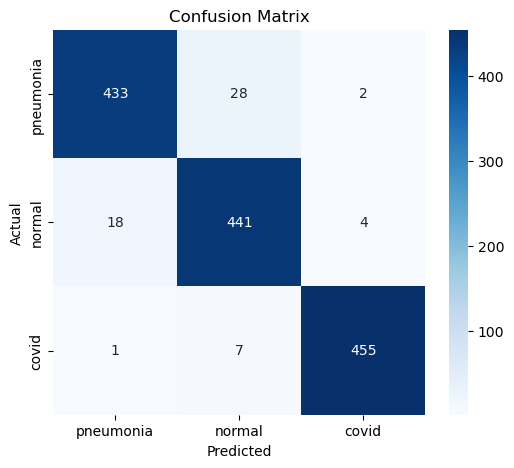

In [43]:
cm = confusion_matrix(y_true, y_pred_classes)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=CLASS_NAMES, yticklabels=CLASS_NAMES)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

In [45]:
def preprocess_external_image(img_path):
    img = cv2.imread(img_path)
    if img is None:
        raise ValueError("Image not found or not readable.")
    img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
    img = apply_clahe(img)
    img = img / 255.0
    return np.expand_dims(img, axis=0)  # Add batch dimension

# Path to your external image
external_img_path = r"C:\Users\anuvv\FINAL PROJECT\CONOP\pneumonia\00000165_001.png" # <-- change this

# Preprocess and predict
try:
    processed_img = preprocess_external_image(external_img_path)
    prediction = model.predict(processed_img)
    predicted_idx = np.argmax(prediction)
    predicted_label = CLASS_NAMES[predicted_idx]

    print(f"\nPredicted Disease: {predicted_label}")
    print("Confidence Scores:")
    for i, cls_name in enumerate(CLASS_NAMES):
        print(f"{cls_name}: {prediction[0][i]:.4f}")
except Exception as e:
    print("Error:", e)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 273ms/step

Predicted Disease: pneumonia
Confidence Scores:
pneumonia: 0.9976
normal: 0.0023
covid: 0.0001


In [49]:
def preprocess_external_image(img_path):
    img = cv2.imread(img_path)
    if img is None:
        raise ValueError("Image not found or not readable.")
    img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
    img = apply_clahe(img)
    img = img / 255.0
    return np.expand_dims(img, axis=0)  # Add batch dimension

# Path to your external image
external_img_path = r"C:\Users\anuvv\FINAL PROJECT\CONOP\normal\00000005_003.png" # <-- change this

# Preprocess and predict
try:
    processed_img = preprocess_external_image(external_img_path)
    prediction = model.predict(processed_img)
    predicted_idx = np.argmax(prediction)
    predicted_label = CLASS_NAMES[predicted_idx]

    print(f"\nPredicted Disease: {predicted_label}")
    print("Confidence Scores:")
    for i, cls_name in enumerate(CLASS_NAMES):
        print(f"{cls_name}: {prediction[0][i]:.4f}")
except Exception as e:
    print("Error:", e)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 202ms/step

Predicted Disease: normal
Confidence Scores:
pneumonia: 0.0011
normal: 0.9989
covid: 0.0000


In [51]:
def preprocess_external_image(img_path):
    img = cv2.imread(img_path)
    if img is None:
        raise ValueError("Image not found or not readable.")
    img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
    img = apply_clahe(img)
    img = img / 255.0
    return np.expand_dims(img, axis=0)  # Add batch dimension

# Path to your external image
external_img_path = r"C:\Users\anuvv\FINAL PROJECT\CONOP\covid\2c35005f.png" # <-- change this

# Preprocess and predict
try:
    processed_img = preprocess_external_image(external_img_path)
    prediction = model.predict(processed_img)
    predicted_idx = np.argmax(prediction)
    predicted_label = CLASS_NAMES[predicted_idx]

    print(f"\nPredicted Disease: {predicted_label}")
    print("Confidence Scores:")
    for i, cls_name in enumerate(CLASS_NAMES):
        print(f"{cls_name}: {prediction[0][i]:.4f}")
except Exception as e:
    print("Error:", e)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 215ms/step

Predicted Disease: covid
Confidence Scores:
pneumonia: 0.0000
normal: 0.0000
covid: 0.9999


In [61]:
def build_model():
    base_model = EfficientNetV2S(include_top=False, input_shape=(IMG_SIZE, IMG_SIZE, 3), weights="imagenet")
    base_model.trainable = True
    x = base_model.output
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.001))(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.3)(x)
    outputs = layers.Dense(3, activation='softmax')(x)
    model = tf.keras.Model(inputs=base_model.input, outputs=outputs)
    return model, base_model


In [63]:
model, base_model = build_model()


In [65]:
heatmap = make_gradcam_heatmap(img, model, last_conv_layer_name="block6e_add")


C:\Users\anuvv\anaconda3\Lib\site-packages\keras\src\models\functional.py:238: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: [['keras_tensor_2084']]
Received: inputs=Tensor(shape=(1, 224, 224, 3))
  warnings.warn(msg)


In [67]:
def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    grad_model = tf.keras.models.Model(
        [model.inputs], [model.get_layer(last_conv_layer_name).output, model.output]
    )
    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(predictions[0])
        class_channel = predictions[:, pred_index]
    grads = tape.gradient(class_channel, conv_outputs)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
    conv_outputs = conv_outputs[0]
    heatmap = conv_outputs @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()


In [69]:
# Pick a random validation image to visualize
idx = random.randint(0, len(X_val) - 1)
img = X_val[idx:idx+1]

heatmap = make_gradcam_heatmap(img, model, last_conv_layer_name="block6e_add")


In [73]:
import matplotlib.pyplot as plt
import matplotlib.cm as mpl_cm


C:\Users\anuvv\AppData\Local\Temp\ipykernel_22728\3286794706.py:6: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colored_heatmap = mpl_cm.get_cmap("jet")(heatmap_rescaled / 255.0)
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.011764705882352941..1.3215686274509804].


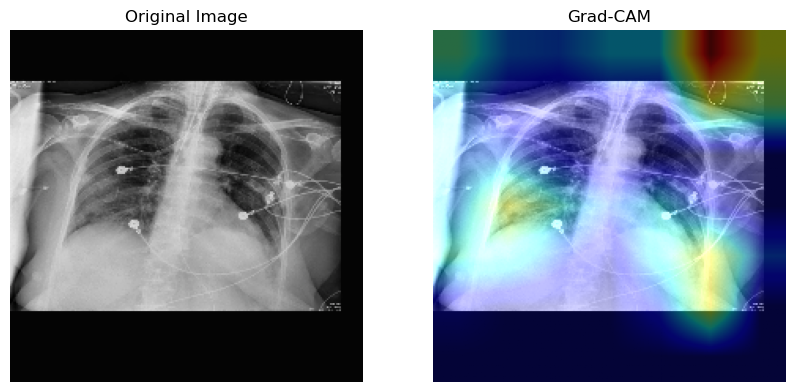

In [75]:
# Overlay
img_original = (img[0] * 255).astype("uint8")
heatmap_resized = cv2.resize(heatmap, (IMG_SIZE, IMG_SIZE))
heatmap_rescaled = np.uint8(255 * heatmap_resized)
# colored_heatmap = cm.get_cmap("jet")(heatmap_rescaled / 255.0)
colored_heatmap = mpl_cm.get_cmap("jet")(heatmap_rescaled / 255.0)
colored_heatmap = np.delete(colored_heatmap, 3, 2)  # Remove alpha
superimposed_img = colored_heatmap * 0.4 + img_original / 255.0

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(img_original)
plt.title("Original Image")
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(superimposed_img)
plt.title("Grad-CAM")
plt.axis('off')
plt.show()